### 1. 모듈 경로 설정 및 필요 모듈 임포트

In [1]:
import os
import sys
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

scripts_path = os.path.join(project_root, 'scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

yolov5_path = os.path.join(project_root, 'yolov5')
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)

from scripts.utils import *

/home/vscode/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. 모델 파인튜닝

In [ ]:
download_images_from_rb()

In [ ]:
# data.yaml 파일 경로 설정
data_yaml_path = '../yolov5/data/roboflow/data.yaml'

latest_exp_dir = find_latest_exp_dir()
best_weights_path = os.path.join(latest_exp_dir, 'weights', 'best.pt')
print(f'Using weights from: {best_weights_path}')

In [ ]:
# 모델 파인튜닝 실행
!python ../yolov5/train.py --img 640 --batch 16 --epochs 10 --data {data_yaml_path} --weights yolov5m.pt --cache

### 3. 허깅페이스에 업로드

In [ ]:
hf_login()

latest_exp_dir = find_latest_exp_dir()

repo_name = "jspark2000/yolov5-vehicle"
local_model_dir = os.path.join(latest_exp_dir, 'weights')
filenames = ["best.pt", "last.pt"]

upload_model_to_hf(repo_name, local_model_dir, filenames)

### 4. 허깅페이스에서 다운로드 후 테스트

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/vscode/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-6-11 Python-3.11.9 torch-2.2.1 CPU

Found https://huggingface.co/jspark2000/yolov5-vehicle/resolve/main/best.pt locally at best.pt
Fusing layers... 
Model summary: 212 layers, 20893344 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


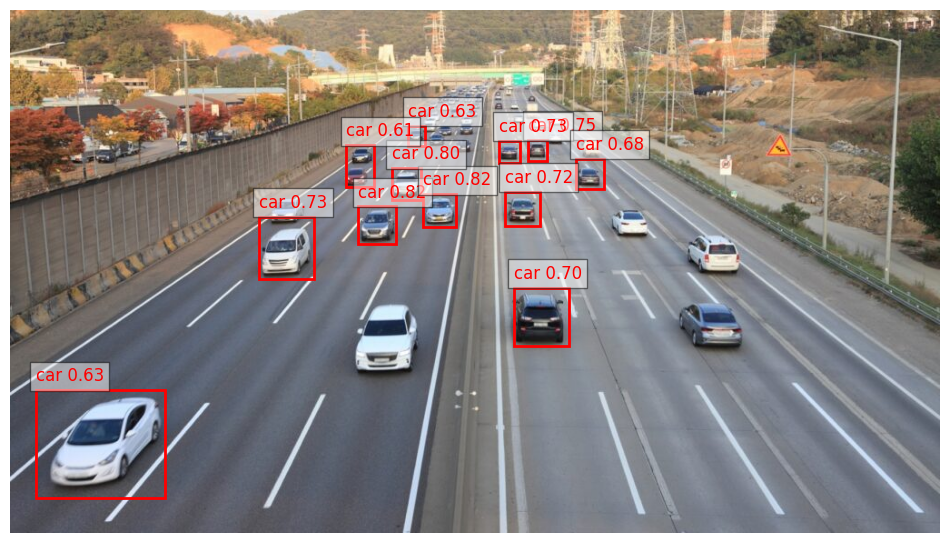

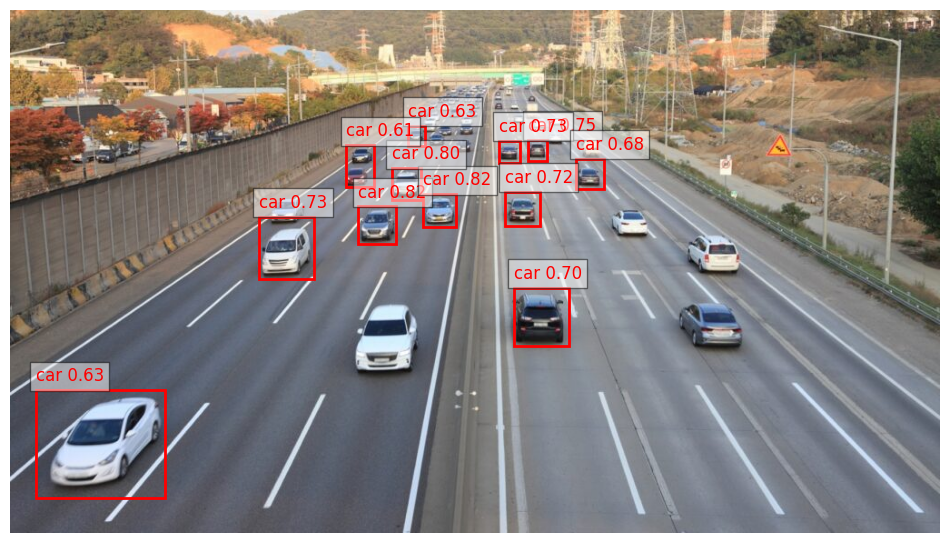

In [3]:

%matplotlib inline

hf_path = 'https://huggingface.co/jspark2000/yolov5-vehicle/resolve/main/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=hf_path, force_reload=True)

image_path = "../images/sample.jpg"
img = Image.open(image_path)

results = model(img)
results_df = results.pandas().xyxy[0]

threshold = 0.6
filtered_results = results_df[results_df['confidence'] >= threshold]

np_img = np.array(img)

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(np_img)

for index, row in filtered_results.iterrows():
    xmin, ymin, xmax, ymax, confidence, class_id, name = row
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    label = f'{name} {confidence:.2f}'
    plt.text(xmin, ymin - 10, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.axis('off')
plt.show()